# Restauração de Imagens - Filtro de Wiener


O filtro de Wiener é aplicado em processamento de imagens para a remoção de ruídos, realizada com base em uma análise estatística que considera o ruído como uma variável aleatória e busca estimar o mínimo erro quadrático entre a imagem estimada (resultante da análise do mínimo erro quadrático) e a imagem original

Nesse notebook, buscamos obter um coeficiente de balanço para o filtro de Wiener que minimize a Raíz Quadrada do Erro Médio (RMSE) entre a imagem restaurada e a imagem original, fazendo isso através da automatização da geração dos coeficientes de balanço e do cálculo da RMSE para cada imagem resultante da aplicação do filtro para cada coeficiente. Uma vez tendo os valores computados, analisamos qual dos coeficientes apresentou o menor RMSE e então recuperamos a imagem relacionada a ele para compararmos com a imagem original e com a degradada

## Bibliotecas utilizadas

In [36]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage import restoration
from math import sqrt, ceil
from scipy.signal import convolve2d

## Funções

### Raíz Quadrada do Erro Médio (Root Mean Squared Error - RMSE)

Para avaliar a similaridade entre a imagem resultante da aplicação do filtro de Wiener utilizamos a abordagem da Raíz Quadrada do Erro Médio, expressa pela fóruma abaixo

<center>$RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_{i} - \hat{y_i})^2}$</center>

Onde $N$ é o número de pixels na imagem, e $y_i - \hat{y_i}$ é a diferença entre o pixel da imagem original e da imagem restaurada pelo filtro

A implementação dessa fórmula foi feita na função **RMSE()** abaixo

In [37]:
def RMSE(image, corrupted_image):
  errors = []
  N = image.shape[0] * image.shape[1]
  sum = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      error = (int(image[i][j]) - int(corrupted_image[i][j]))**2
      sum += error
      errors.append(error)
  square_root = sqrt(sum)
  rmse = square_root/N
  return rmse

### Geração do kernel gaussiano

Utilizamos a função abaixo para gerar um kernel gaussiano que será usado para degradar a imagem juntamente com o ruído aplicado

In [38]:
def gaussian_filter(k=5, sigma=2.0):
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
    return filt / np.sum(filt)

### Geração da Point Spread Function (PSF)

A PSF gerada pela função **generate_psf()** degrada a imagem de entrada, aplicando o kernel gaussiano gerado pela função **gaussian_filter()**, levando em conta os parâmetros recebidos. Após isso, ela aplica ruído à imagem, com intensidade definida pelo parâmetro noise_coefficient e então retorna a imagem degradada e a PSF

In [39]:
def generate_psf(image, kernel_size, sigma, noise_coefficient):
  psf = gaussian_filter(k=kernel_size, sigma=sigma)
  conv = convolve2d(image, psf, 'same')
  rng = np.random.default_rng()
  noised = conv + noise_coefficient * conv.std() * rng.standard_normal(conv.shape)
  return noised, psf

### Lista com as imagens restauradas para cada coeficiente de balanço

 A função **restored_images_list()** retorna uma lista com as imagens normalizadas resultantes da aplicação do filtro de Wiener para os coeficientes de balanço definidos na lista **balance_values** passada como parâmetro; cada coeficiente de **balance_values** é associado à imagem na lista retornada, estando ambos em posições correspondentes das suas listas. Além disso, a função recebe o argumento **psf**, que é o kernel gaussiano usado para degradar a imagem, obtido da função **generate_psf()**

In [40]:
def restored_images_list(corruped_image, psf, balance_values):
  return [restoration.wiener(corruped_image, psf, balance=b) for b in balance_values]

### Aplicação da RMSE para cada imagem resultante da aplicação do filtro de Wiener

 A função **RMSE_evaluation()** retorna uma lista com os valores resutantes da aplicação da Raíz Quadrada do Erro Médio para cada imagem restaurada e a imagem original

In [41]:
def RMSE_evaluation(normalized_original_image, normalized_restored_images):
  return [RMSE(normalized_original_image*255.0, normalized_restored_image*255.0) for normalized_restored_image in normalized_restored_images]

### Restauração da imagem com o filtro de Wiener

A função abaixo é usada para facilitar a aplicação do filtro de Wiener para imagens normalizadas em determinados casos

In [42]:
def image_restoration(normalized_corrupted_image, psf, balance):
  restored_image = restoration.wiener(normalized_corrupted_image, psf, balance=balance)
  result = restored_image*255.0
  cv2_imshow(result)
  return result

## Degradação da imagem

### Imagem original

Considerando a imagem original mostrada abaixo

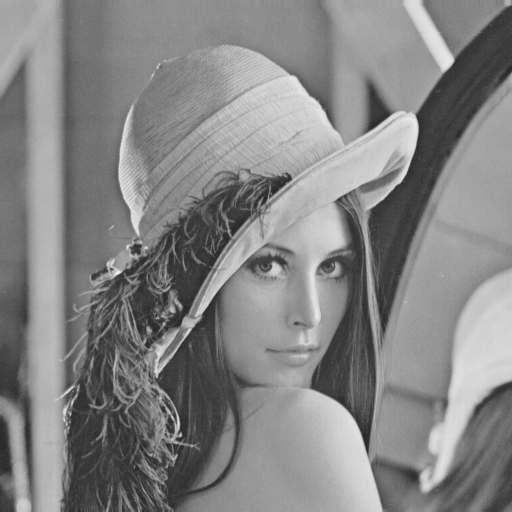

In [43]:
image = cv2.imread('lena.png', 0)
image = image.astype(np.float64)
image = image/255.0
cv2_imshow(image*255.0)

### Imagem degradada

Usamos a função **generate_psf()** para degradá-la e retornar a Point Spread Function utilizada

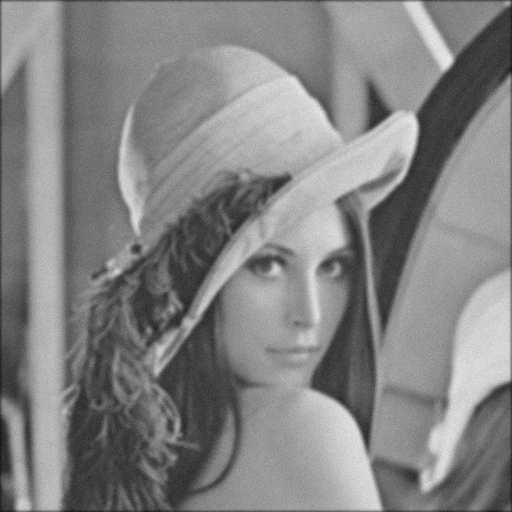

In [44]:
noised, psf = generate_psf(image, kernel_size=7, sigma=2.0, noise_coefficient=0.1)
cv2_imshow(noised*255.0)

## Estimativa do mínimo e máximo coeficientes de balanço para a restauração

Com o objetivo de gerar um intervalo de valores para o coeficiente de balanço usados no filtro de Wiener para a análise das imagens restauradas, podemos inferir que existe um valor mínimo e um valor máximo para o intervalo para os quais a qualidade da imagem não é conveniente. Considerando que quanto menor for o valor do balanço o filtro o ruído tende a aumentar e que quanto maior for o valor, o ruído tende a dimunir e borramento da imagem resultante tende a aumentar, o intervalor não deve considerar os valores menores que o valor mínimo (pois para eles o ruído aumentaria acima de um nível aceitável) e nem os valores maiores que o valor máximo (pois para eles o borramento aumetaria acima de um nível aceitável)

Com base nisso, buscamos obter os limites inferior e superior do intervalo para o qual os testes serão realizados

### Para o coeficiente de balanço = 0

Considerando o resultado abaixo para o valor 0 atribuído ao coeficiente de balanço, é fácil concluir que esse valor não deve nem mesmo ser considerado no intervalo devido ao nível de ruído obtido

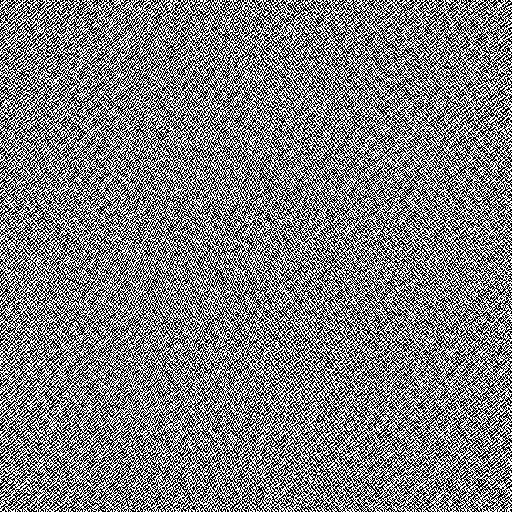

In [45]:
image_restoration(noised, psf, balance=0);

### Para o coeficiente de balanço = 0.01

Embora que para o valor 0.01 para o coeficiente de balanço a imagem seja bem distinguível, podemos ver que o nível de ruído ainda é relativamente alto, mesmo quando comaprado com a imagem degradada. Dessa forma, como o objetivo é reduzir o ruído, não é conveniente considerar um valor que gera um nível de ruídio tão alto

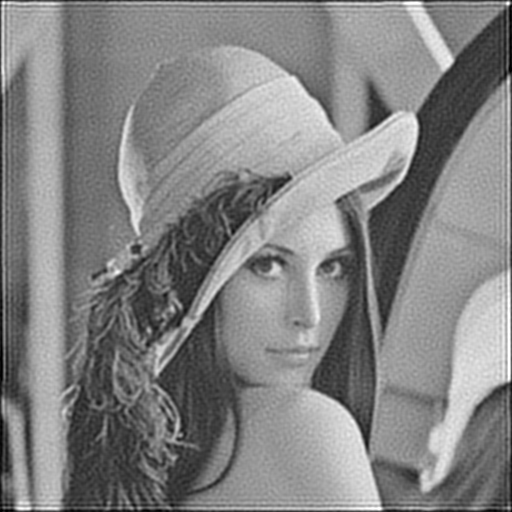

In [46]:
image_restoration(noised, psf, balance=0.01);

Para o valor 0.1, o ruido ainda é relativamente alto, mas menor que o resultante o valor 0.01. Considerando ainda que o valor 0.1 é conveniente para gerar saltos entre valores a serem testados, podemos considerá-lo como o valor mínimo do intervalo e a partir dele obter os outros valores com saltos de 0.1 em 0.1 até obter o valor máximo

Assim, o limite inferior conveniente para o intervalo é 0.1

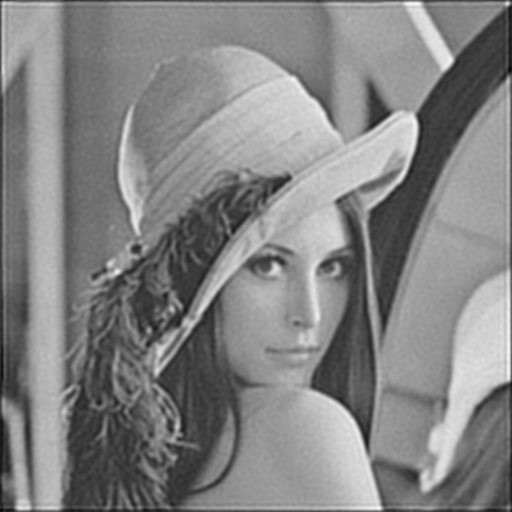

In [47]:
image_restoration(noised, psf, balance=0.1);

### Para o coeficiente de balanço = 100

Com o objetivo de obter o limite superior para o intervalo, analisamos inicialmente a qualidade da imagem para o coeficiente de balanço 100, como mostrado abaixo

O resultado é uma imagem com detalhes difíceis de distinguir, dada o nível de borramento dela. Desta forma, podemos tomar 100 como o valor máximo para o intervalo pois sabemos que para ele a qualidade da imagem já está comprometida e também por ser um valor conveniente com os saltos de 0.1

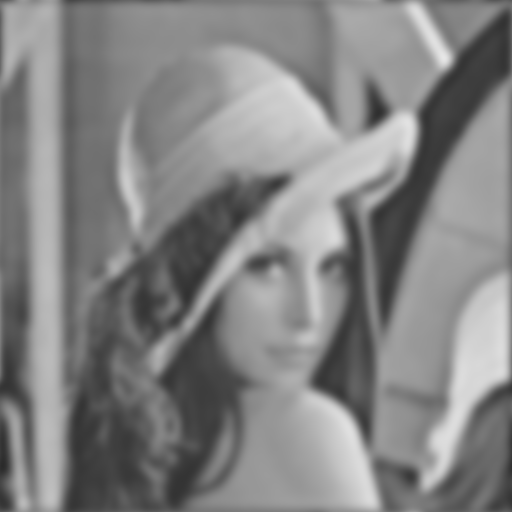

In [48]:
image_restoration(noised, psf, balance=100);

De fato, podemos ver que para um valor de 300 do coeficiente de balanço, os detalhes se tornam mais indistinguíveis ainda

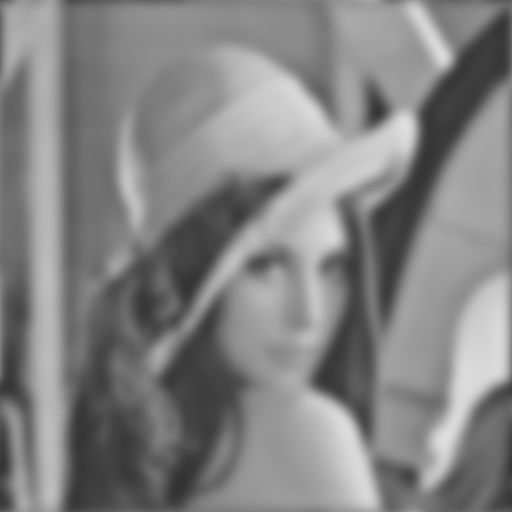

In [49]:
image_restoration(noised, psf, balance=300);

Desta forma, obtemos 0.1 como o menor valor para o intervalo e 100 como o maior valor. Com isso, geramos um intervalo discreto de 0.1 até 100 com saltos de 0.1 em 0.1 a partir do valor inicial, gerando 1000 valores totais no intervalo

## Estimativa automatizada do valor do coeficiente de balanceamento

### Geração da lista de coeficientes de balanceamento

Tendo os valores mínimo e máximo para o intervalo, o bloco de código abaixo gera o intervalo de valores discretos para o coeficiente de balanço e os armazena na lista **balance_values**

In [50]:
balance_values = []
balance_value = 0
while (True):
  balance_value += 0.1
  balance_value = round(balance_value,1)
  balance_values.append(balance_value)
  if (balance_value == 100): break

In [51]:
len(balance_values)

1000

### Obtenção da menor RMSE o seu índice correspondente

A célula abaixo aplica as funções **restored_images_list()** e **RMSE_evaluation()** de modo a gerar as imagens para cada coeficiente do intervalo obtido e calcular a RMSE para cada uma delas. Uma vez obtidos os valores da RMSE, recuperamos o menor deles e o seu índice correspondente, que corresponde ao índice da imagem com o melhor resultado da aplicação do filtro na lita **restored_images**

In [52]:
restored_images = restored_images_list(noised, psf, balance_values)
results = RMSE_evaluation(image, restored_images)
index = np.where(results == np.min(results))[0][0]
print('Menor RMSE',results[index])
print('Índice da menor RMSE', index)

Menor RMSE 0.019318600565283367
Índice da menor RMSE 3


### Melhor valor para ocoeficiente de balanceamento dentre os valores do intervalo


Para esse caso (com o ceficiente de ruído de 0.1) o melhor valor obtido para o coeficente de balanceamento foi 0.4

In [53]:
balance_values[index]

0.4

### Melhor resultado da aplicação do filtro para os valores de coeficiente de balanço no intervalo

Abaixo é mostrado o melhor resultado da aplicação do filtro para os valores em **balance_values** (que corresponde a aplicação do filtro de Wiener com o coeficiente de balanceamento de 15.1)

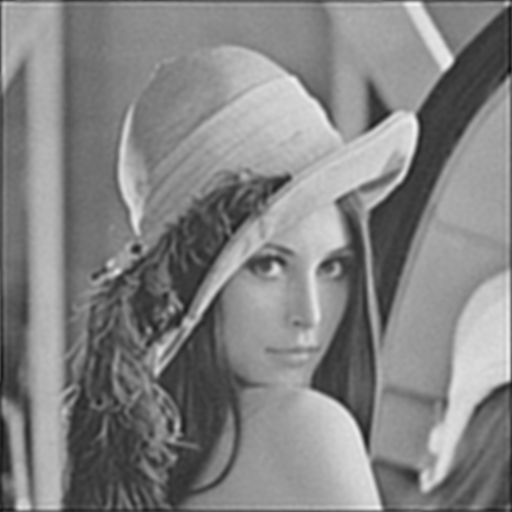

In [55]:
best_result = restored_images[index]*255.0
cv2_imshow(best_result)

## Comparação da imagem original com a degrada e com a restaurada

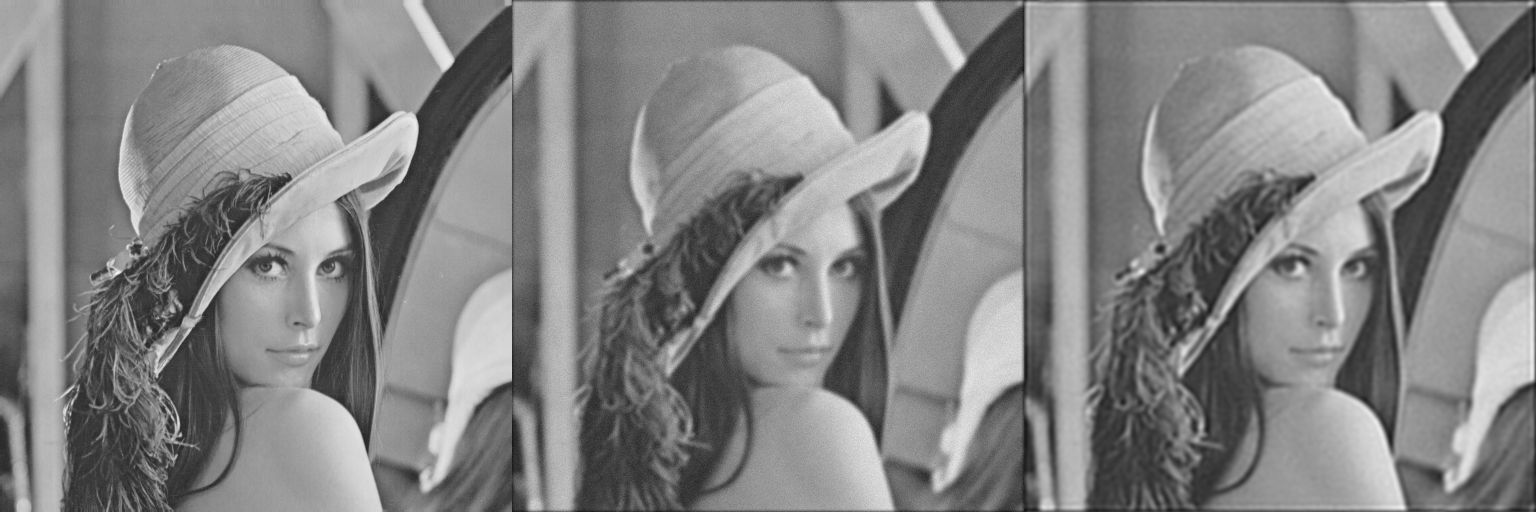

In [56]:
images = np.hstack((image*255.0, noised*255.0, best_result))
cv2_imshow(images)

## Conclusão

O resutlado obtido foi o melhor tendo em vista a abordagem da Raíz Quadrada do Erro Médio para os valores **do intervalo discreto considerado**. Se trata do melhor resultado dentro do intervalo considerado, mas não se pode dizer que é o melhor dentre os infinitos valores possíveis. Para uma melhor aproximação, pode-se utilizar a mesma estratégia mostrada nesse notebook para intervalos com valores mais limitados em cujos limites sabemos que o coeficiente que gera o melhor resutlado se encontra e então utilizar saltos menores entre os valores discretos desse intervalo